# 1. Introdução

Nesse notebook iremos utilizar uma base de dados com algumas informações sobre suicídios nos países, para tentar entender fatores que influenciam nessa decisão.

# 2. Imports e Funções


In [ ]:
# Para evitar avisos que iriam atrapalhar a visualização de dados
from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)

# Pacote de ML utilizado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score

# Ferramentas Estatísticas
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as ss

# Pacote básico de manipulação e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Padronização dos gráficos para facilitar visualização.

In [ ]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

Força o gráfica a ser desenhado no próprio notebook.

In [ ]:
plt.ion()

Função que retira as linhas das bordas direita e superior dos gráficos.

In [ ]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

Função que calcula o bootstrap com 5000 valores do conjunto de dados x passado.

In [ ]:
def bootstrap_mean(x, n=5000):
    size = len(x)
    values = np.zeros(n)
    for i in range(n):
        sample = np.random.choice(x, size=size, replace=True)
        values[i] = sample.mean()
    return values

Função que calcula o bootstrap com 5000 valores do MSE (Erro Médio Quadrado) do modelo passado.

In [ ]:
def bootstrap_mse(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X.iloc[idx]
        yb = y.iloc[idx]
        values[i] = mean_squared_error(yb, model.predict(Xb))
    return values

Função que calcula o bootstrap com 5000 valores do score do modelo passado. Ela não será utilizada nesse notebook, mas pode ser útil caso o leitor queira utilizar outra métrica para avaliar os modelos.

In [ ]:
def bootstrap_score(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X.iloc[idx]
        yb = y.iloc[idx]
        values[i] = model.score(Xb, yb)
    return values

Função que calcula o bootstrap com 5000 valores do score do modelo passado. Ela não será utilizada nesse notebook, mas pode ser útil caso o leitor queira utilizar outra métrica para avaliar os modelos.

In [ ]:
def bootstrap_pscore(y_val, y_hat, n=5000):
    size = len(y_val)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        y_valb = y_val[idx]
        y_hatb = y_hat[idx]
        values[i] = precision_score(y_valb, y_hatb, average=None)
    return values

# 3. Base de Dados

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSVs/suicide rates.csv', encoding='utf-8', sep=',', thousands=',')

In [ ]:
df.head()

,Country,Year,Sex,Age,Suicides,Population,Suicides/100k,HDI,GDP,GDP per capita,Generation
0,Albania,1987,male,15-24 years,21,312900,6.71,NaN,2156624900,796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,NaN,2156624900,796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,NaN,2156624900,796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,NaN,2156624900,796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,NaN,2156624900,796,Boomers


## 1. Visualização Inicial


Somente a coluna 'HDI' possui NaNs. Iremos lidar com esse problema em um momento mais oportuno.

In [ ]:
df.isna().sum().sort_values(ascending=False)

HDI               19456
Generation            0
GDP per capita        0
GDP                   0
Suicides/100k         0
Population            0
Suicides              0
Age                   0
Sex                   0
Year                  0
Country               0
dtype: int64

In [ ]:
df.shape

(27820, 11)

Suicídio por idade.

In [ ]:
df[['Country', 'Age', 'Suicides/100k']].groupby(by='Country').mean().sort_values(by='Suicides/100k')[-15:]

,Suicides/100k
Country,
Guyana,22.186400
Finland,22.770431
Croatia,22.835267
Austria,23.759764
Republic of Korea,25.135618
Ukraine,26.582321
Estonia,27.276905
Slovenia,27.827857
Latvia,29.259325


In [ ]:
filtro = df['Population'] > 1e6
df[filtro][['Country', 'Age', 'Suicides/100k']].groupby(by='Country').mean().sort_values(by='Suicides/100k')[-15:]

,Suicides/100k
Country,
Sweden,17.809125
Serbia,18.043200
Cuba,18.069875
Switzerland,18.612143
Czech Republic,19.045761
Austria,20.359434
Japan,21.573199
France,21.675694
Ukraine,22.200584


In [ ]:
df['Country'].unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

In [ ]:
# dfx = df[df['Country'] == 'Republic of Korea']

In [ ]:
# dfx

In [ ]:
# df[['Country', 'Age', 'Population']].groupby(by='Country').sum().iloc[73]

## 2. Limpeza dos Dados


Separamos a coluna com os nomes dos países.

In [ ]:
col = 'Country'
countries = df[col]

Tiramos o 'years' da columa 'Age'.

In [ ]:
df['Age'] = df['Age'].str.replace(' years', '')

Aqui substituimos os NaNs restantes pela média da coluna.

In [ ]:
#df = df.fillna(df.mean())

# 4. Visualização de Dados


## 2. Visualização da Expectativa de Vida

Da mesma maneira que o GDP, a distribuição da Expectativa de Vida não é simétrica, entretanto, a intensidade dessa assimetria é bem menor. Além do que, nesse caso, existem muitos países com a Expectativa de Vida parecida e relativamente alta, ao invés do contrário.

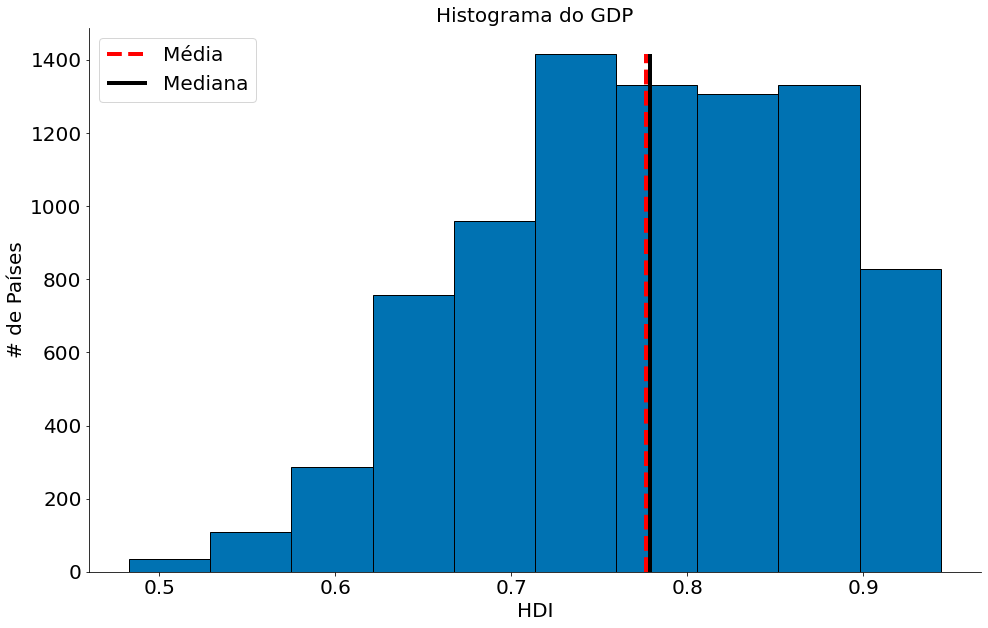

In [ ]:
col = 'HDI'

x = df[col]

ymin = 0

n, bins, patches = plt.hist(x, bins=10, edgecolor='k')
plt.vlines(x.mean(), ymin, n.max(), label='Média', linestyles='--', edgecolor='k', color='red')
plt.vlines(x.median(), ymin, n.max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma do GDP')

plt.legend()

despine()

plt.show()

# 5. Testes de Hipóteses

## 1. Testes da Expectativa de Vida

Aqui faremos o bootstrap e calcularemos intervalos de confiança para mostrar uma possível correlação entre Expectativa de Vida e GDP.

Para isso, criaremos duas "classes", os países que possuem a Expectativa de Vida acima da média e aqueles que a possuem abaixo da média. Iremos ignorar a média já que a usamos para preencher os NaNs.

Como o leitor pode acompanhar, os ICs não se cruzam, o que significa, que, estatisticamente falando, o acaso não é capaz de explicar essa diferença.

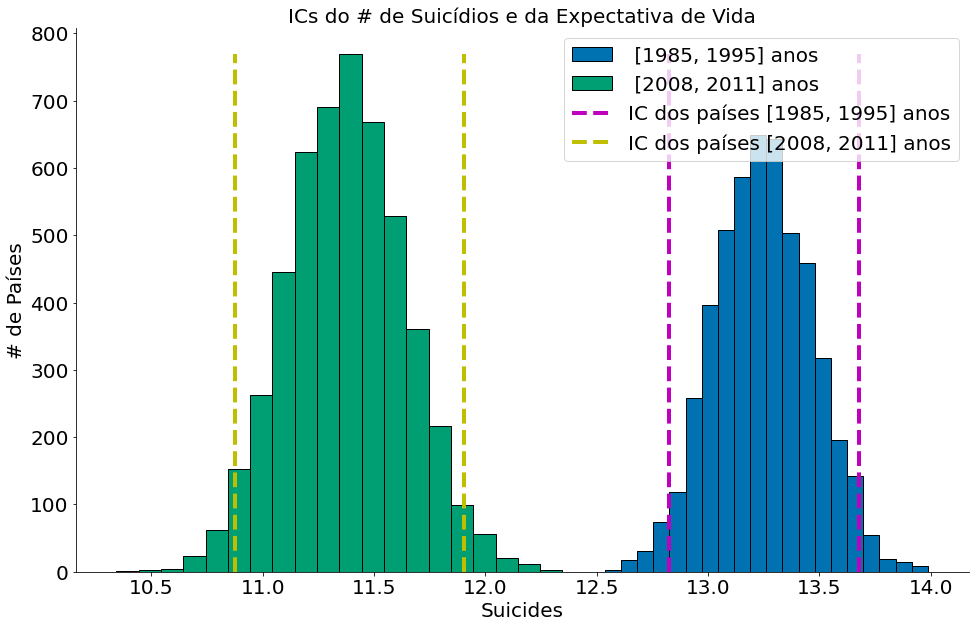

In [ ]:
col = 'Year'
corte = [1985, 1995, 2008, 2011]

filtro = (df[col] >= corte[0]) & (df[col] <= corte[1])
df0 = df['Suicides/100k'][filtro]

filtro = (df[col] >= corte[2]) & (df[col] <= corte[3])
df1 = df['Suicides/100k'][filtro]

df0_mean = bootstrap_mean(df0)
df1_mean = bootstrap_mean(df1)

LI0 = np.percentile(df0_mean, 2.5)
LS0 = np.percentile(df0_mean, 97.5)
LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=' [' + str(corte[0]) + ', ' + str(corte[1]) + '] anos')

maior.append(n.max())

n, bins, patches = plt.hist(df1_mean, bins=20, edgecolor='k', label=' [' + str(corte[2]) + ', ' + str(corte[3]) + '] anos')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC dos países' + ' [' + str(corte[0]) + ', ' + str(corte[1]) + '] anos', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC dos países' + ' [' + str(corte[2]) + ', ' + str(corte[3]) + '] anos', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

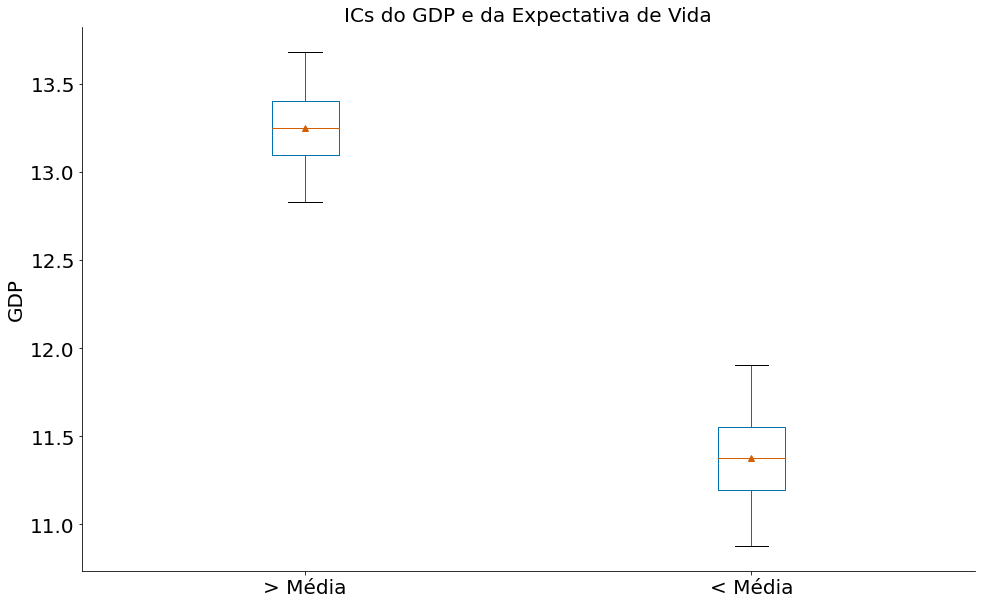

In [ ]:
df2 = pd.DataFrame()

df2['> Média'] = df0_mean
df2['< Média'] = df1_mean

df2.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

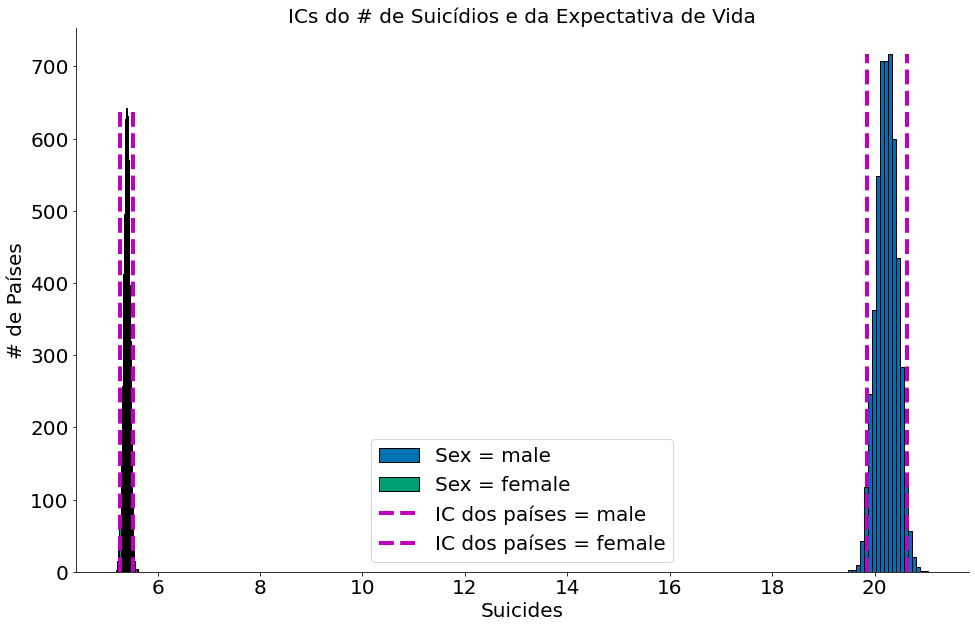

In [ ]:
ymin = 0
col = 'Sex'
corte = df[col].unique()

for i in corte:
    filtro = df[col] == i
    df0 = df['Suicides/100k'][filtro]

    df0_mean = bootstrap_mean(df0)

    LI = np.percentile(df0_mean, 2.5)
    LS = np.percentile(df0_mean, 97.5)

    n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' = ' + i)

    maior = n.max()

    plt.vlines(LI, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + i, color='m')
    plt.vlines(LS, ymin, maior, linestyles='--', edgecolor='m')

plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

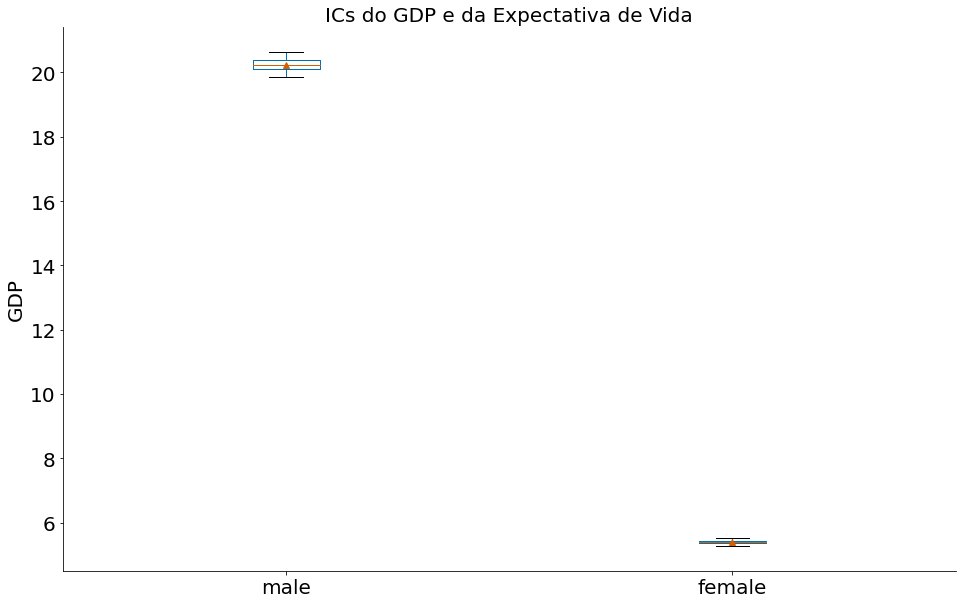

In [ ]:
col = 'Sex'
corte = df[col].unique()
df1 = pd.DataFrame()

for i in corte:
    filtro = df[col] == i
    df0 = df['Suicides/100k'][filtro]

    df0_mean = bootstrap_mean(df0)

    df1[i] = df0_mean

df1.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)

plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

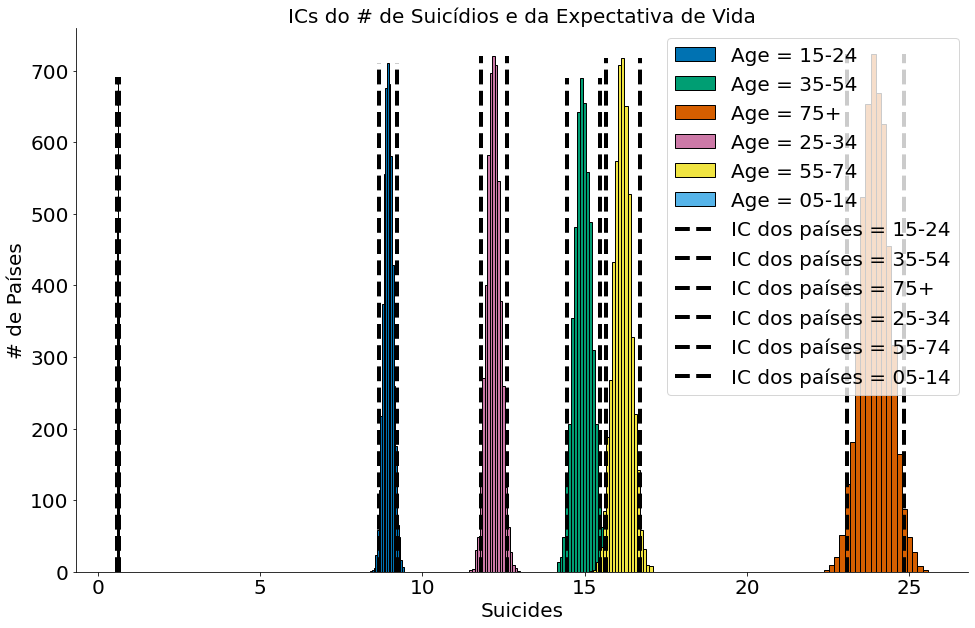

In [ ]:
ymin = 0
col = 'Age'
corte = df[col].unique()

color = iter(cm.rainbow(np.linspace(0, 1, len(corte))))

for i in corte:
    filtro = df[col] == i
    df0 = df['Suicides/100k'][filtro]

    df0_mean = bootstrap_mean(df0)

    LI = np.percentile(df0_mean, 2.5)
    LS = np.percentile(df0_mean, 97.5)

    c = next(color)
    # n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' = ' + i, color=c)
    n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' = ' + i)

    maior = n.max()

    plt.vlines(LI, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + i, color='k')
    plt.vlines(LS, ymin, maior, linestyles='--', color='k')

plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

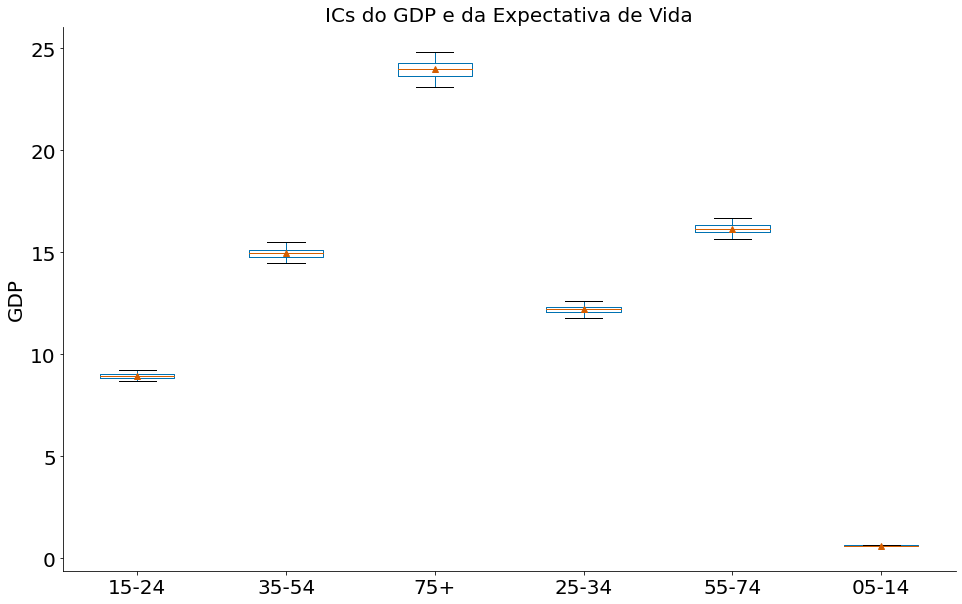

In [ ]:
col = 'Age'
corte = df[col].unique()
df1 = pd.DataFrame()

for i in corte:
    filtro = df[col] == i
    df0 = df['Suicides/100k'][filtro]

    df0_mean = bootstrap_mean(df0)

    df1[i] = df0_mean

df1.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)

plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

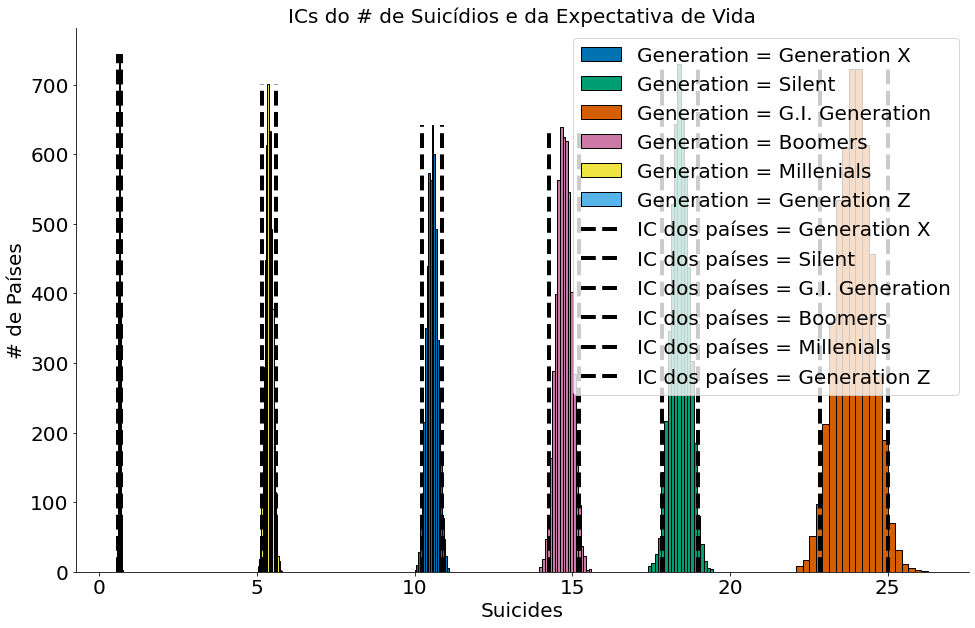

In [ ]:
ymin = 0
col = 'Generation'
corte = df[col].unique()

color = iter(cm.rainbow(np.linspace(0, 1, len(corte))))

for i in corte:
    filtro = df[col] == i
    df0 = df['Suicides/100k'][filtro]

    df0_mean = bootstrap_mean(df0)

    LI = np.percentile(df0_mean, 2.5)
    LS = np.percentile(df0_mean, 97.5)

    c = next(color)
    n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' = ' + i)
    # n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' = ' + i, color=c)

    maior = n.max()

    plt.vlines(LI, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + i, color='k')
    plt.vlines(LS, ymin, maior, linestyles='--', color='k')

plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

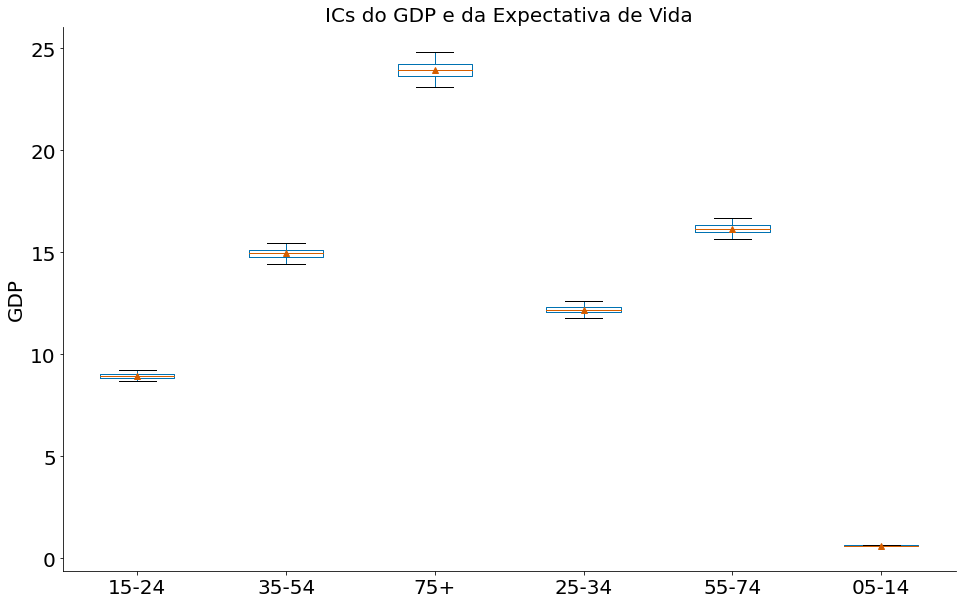

In [ ]:
col = 'Age'
corte = df[col].unique()
df1 = pd.DataFrame()

for i in corte:
    filtro = df[col] == i
    df0 = df['Suicides/100k'][filtro]

    df0_mean = bootstrap_mean(df0)

    df1[i] = df0_mean

df1.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)

plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

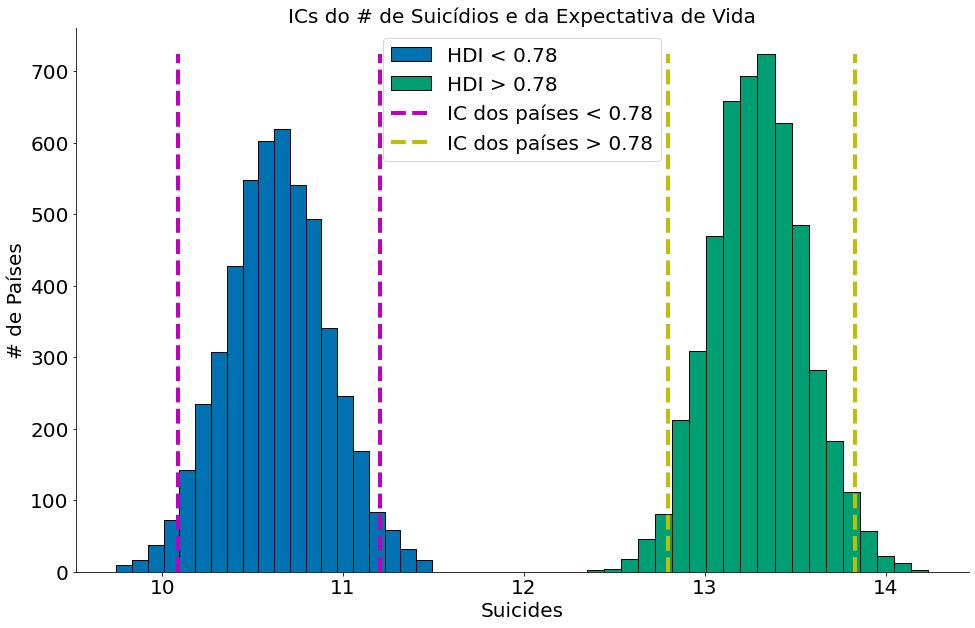

In [ ]:
col = 'HDI'
corte = df[col].mean()

filtro = df[col] < corte
df0 = df['Suicides/100k'][filtro]

filtro = df[col] > corte
df1 = df['Suicides/100k'][filtro]

df0_mean = bootstrap_mean(df0)
df1_mean = bootstrap_mean(df1)

text = str(round(corte, ndigits=2))

LI0 = np.percentile(df0_mean, 2.5)
LS0 = np.percentile(df0_mean, 97.5)
LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' < ' + text)

maior.append(n.max())

n, bins, patches = plt.hist(df1_mean, bins=20, edgecolor='k', label=col + ' > ' + text)

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC dos países' + ' < ' + text, color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC dos países' + ' > ' + text, color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

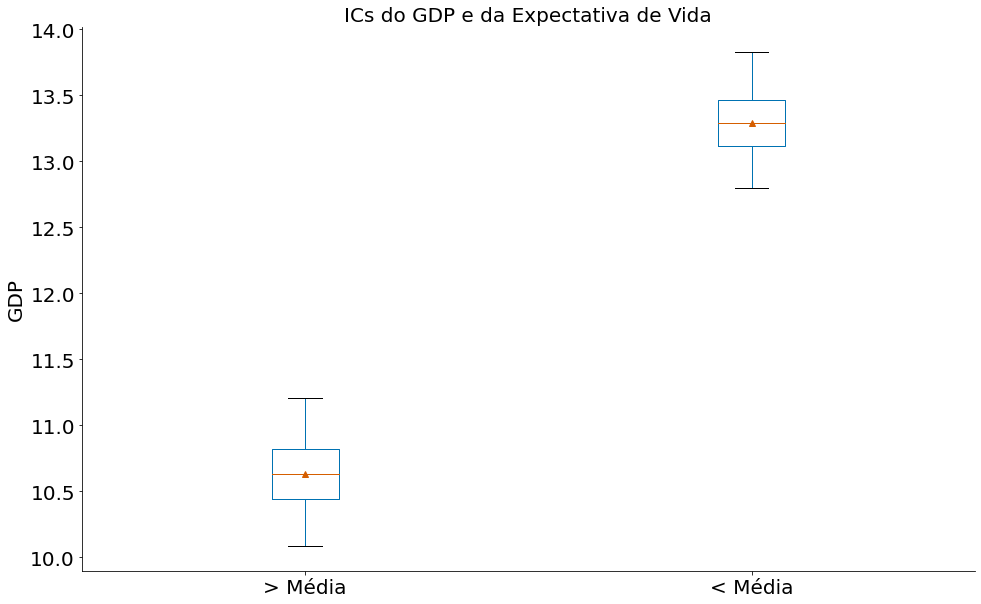

In [ ]:
df2 = pd.DataFrame()

df2['> Média'] = df0_mean
df2['< Média'] = df1_mean

df2.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

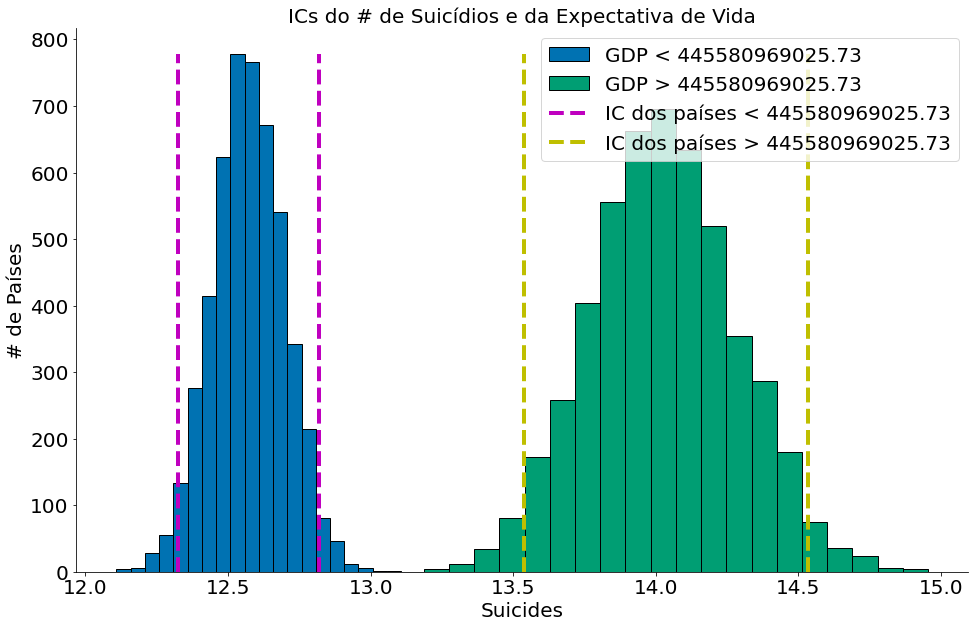

In [ ]:
col = 'GDP'
corte = df[col].mean()

filtro = df[col] < corte
df0 = df['Suicides/100k'][filtro]

filtro = df[col] > corte
df1 = df['Suicides/100k'][filtro]

df0_mean = bootstrap_mean(df0)
df1_mean = bootstrap_mean(df1)

text = str(round(corte, ndigits=2))

LI0 = np.percentile(df0_mean, 2.5)
LS0 = np.percentile(df0_mean, 97.5)
LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' < ' + text)

maior.append(n.max())

n, bins, patches = plt.hist(df1_mean, bins=20, edgecolor='k', label=col + ' > ' + text)

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC dos países' + ' < ' + text, color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC dos países' + ' > ' + text, color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

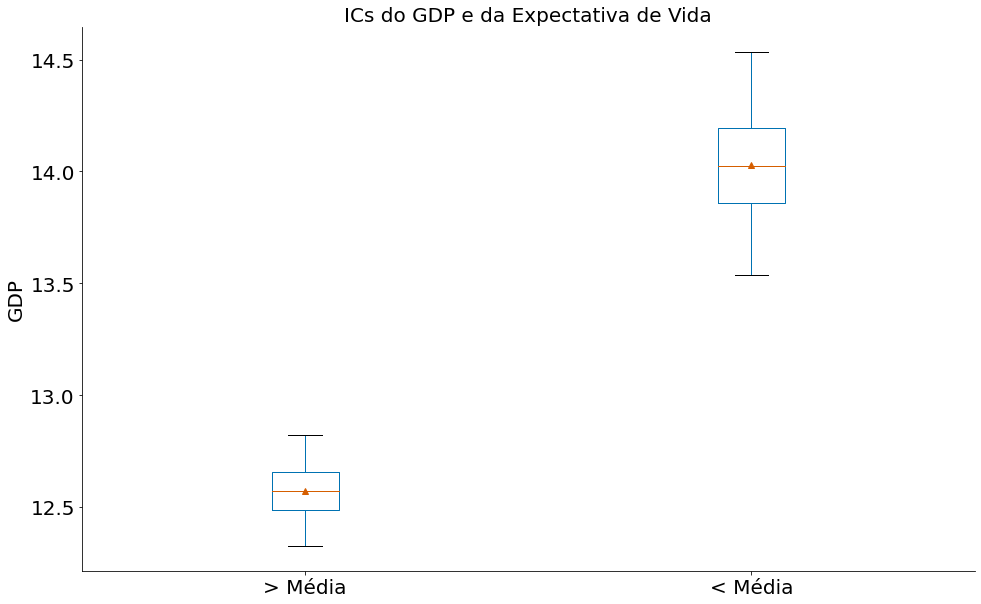

In [ ]:
df2 = pd.DataFrame()

df2['> Média'] = df0_mean
df2['< Média'] = df1_mean

df2.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

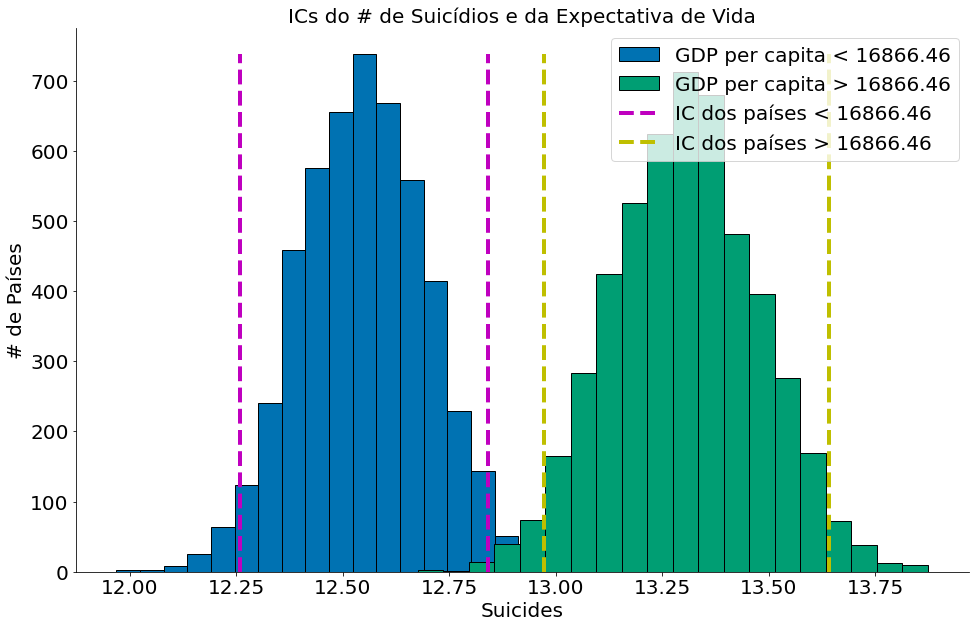

In [ ]:
col = 'GDP per capita'
corte = df[col].mean()

filtro = df[col] < corte
df0 = df['Suicides/100k'][filtro]

filtro = df[col] > corte
df1 = df['Suicides/100k'][filtro]

df0_mean = bootstrap_mean(df0)
df1_mean = bootstrap_mean(df1)

text = str(round(corte, ndigits=2))

LI0 = np.percentile(df0_mean, 2.5)
LS0 = np.percentile(df0_mean, 97.5)
LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' < ' + text)

maior.append(n.max())

n, bins, patches = plt.hist(df1_mean, bins=20, edgecolor='k', label=col + ' > ' + text)

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC dos países' + ' < ' + text, color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC dos países' + ' > ' + text, color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

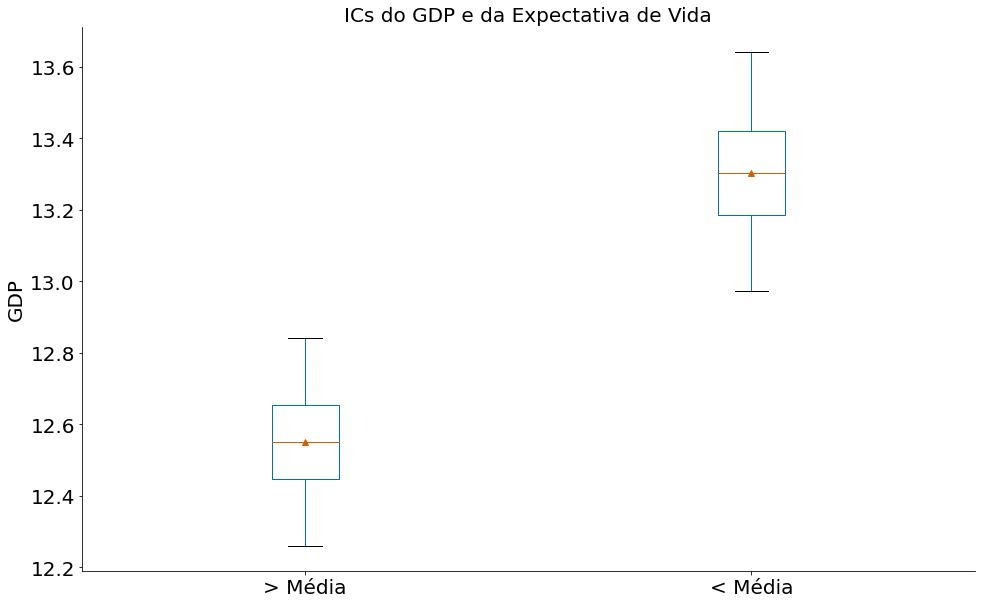

In [ ]:
df2 = pd.DataFrame()

df2['> Média'] = df0_mean
df2['< Média'] = df1_mean

df2.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

### 5. Correlação entre Prevalência do HIV e Expectativa de Vida <a name="hivvida"></a>

Como esperado, parece existir uma correlação entre a Prevalência do HIV e a Expectativa de Vida de uma população. Esse dado é apenas uma curiosidade, já que estamos tentando ver quais fatores têm mais ou menos influência no GDP.

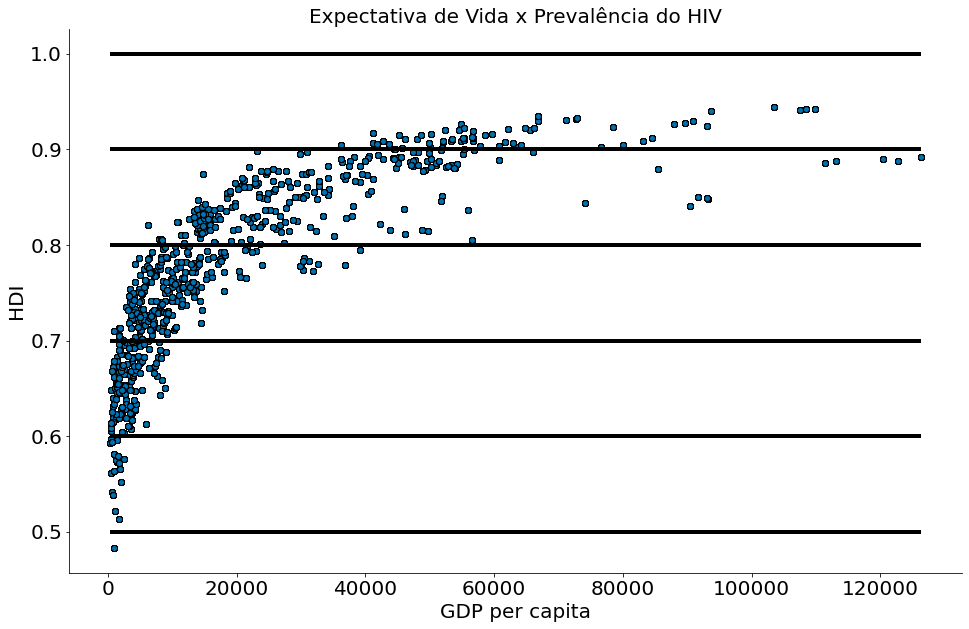

In [ ]:
colx = 'GDP per capita'
coly = 'HDI'

plt.scatter(df.dropna()[colx], df.dropna()[coly], edgecolors='k')
plt.hlines(0.5, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.6, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.7, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.8, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.9, df[colx].min(), df[colx].max(), color='black')
plt.hlines(1, df[colx].min(), df[colx].max(), color='black')
plt.xlabel(colx)
plt.ylabel(coly)
plt.title('Expectativa de Vida x Prevalência do HIV')

despine()

plt.show()

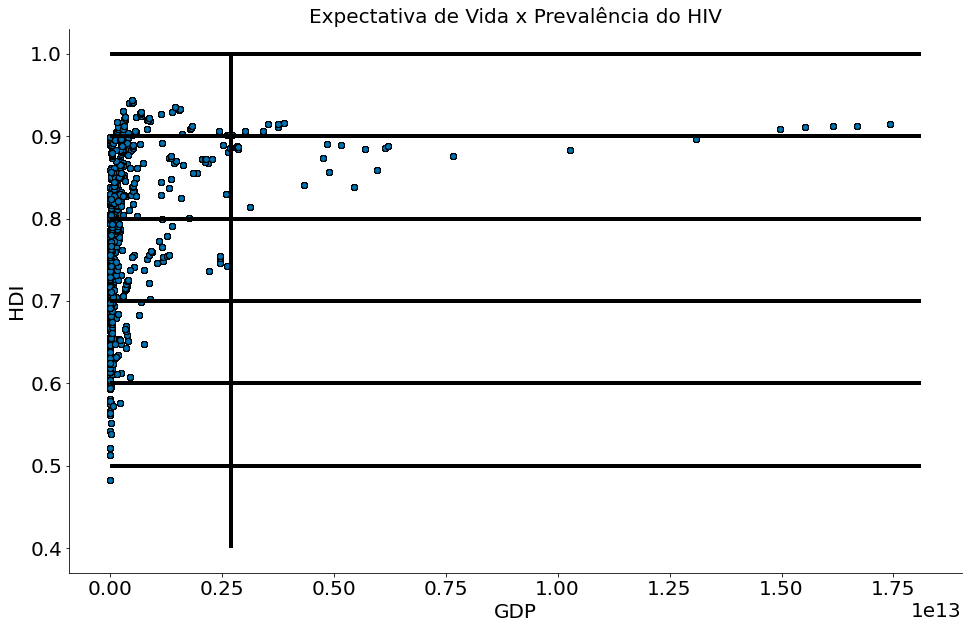

In [ ]:
colx = 'GDP'
coly = 'HDI'

plt.scatter(df.dropna()[colx], df.dropna()[coly], edgecolors='k')
plt.vlines(0.27e13, 0.4, 1, color='black')
plt.hlines(0.5, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.6, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.7, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.8, df[colx].min(), df[colx].max(), color='black')
plt.hlines(0.9, df[colx].min(), df[colx].max(), color='black')
plt.hlines(1, df[colx].min(), df[colx].max(), color='black')
plt.xlabel(colx)
plt.ylabel(coly)
plt.title('Expectativa de Vida x Prevalência do HIV')

despine()

plt.show()

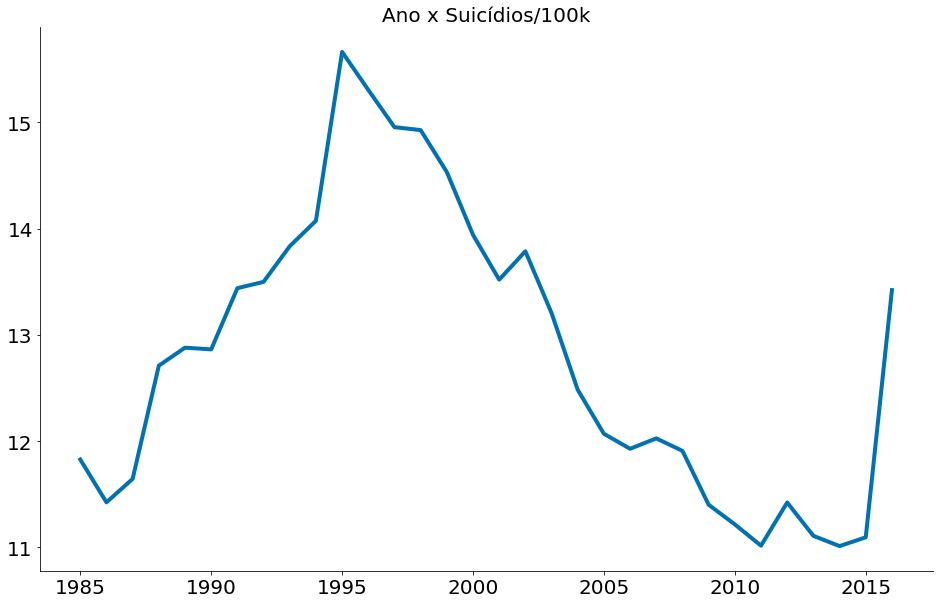

In [ ]:
dx = df[['Country', 'Suicides/100k', 'Year']].groupby(by=['Year', 'Country']).mean().groupby(by='Year').mean()
x = dx.index
y = dx.values

# plt.bar(x, y[:,0])
plt.plot(dx)
plt.title('Ano x Suicídios/100k')

despine()

plt.show()

R2 grau 1: 0.5947923721329338

R2 grau 2: 0.7718696017282385

R2 grau 3: 0.8171223671003517



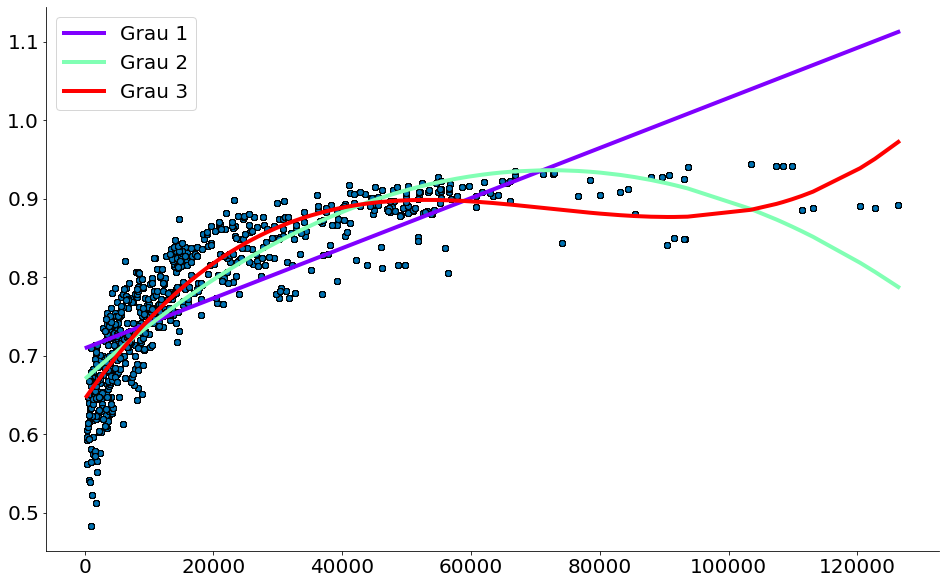

In [ ]:
colx = 'GDP per capita'
coly = 'HDI'

n_iters = 3

color = iter(cm.rainbow(np.linspace(0, 1, n_iters)))

X = df.dropna()[[colx]]
y = df.dropna()[[coly]]

X_sorted = X.sort_values(by=colx)
y_sorted = y.sort_values(by=coly)

sc = StandardScaler()
for k in range(n_iters):
    poly_features = PolynomialFeatures(degree=k+1, include_bias=False)
    lin_reg = LinearRegression()

    poly_reg_model = Pipeline([
        ('std_scaler', sc),
        ('poly', poly_features),
        ('regressor', lin_reg)
    ])
    
    poly_reg_model.fit(X, y)

    y_hat = poly_reg_model.predict(X_sorted)
    
    c = next(color)
    plt.plot(X_sorted, y_hat, color=c, label='Grau ' + str(k+1))
    # print('Coeficientes:', lin_reg.coef_)
    # print('Intercepto:', lin_reg.intercept_)

    precision = poly_reg_model.score(X, y)

    print('R2 grau', str(k + 1) + ':', precision)
    print()

plt.scatter(X, y, edgecolors='k')

plt.legend()

despine()

plt.show()

R2: 0.8335595046146738


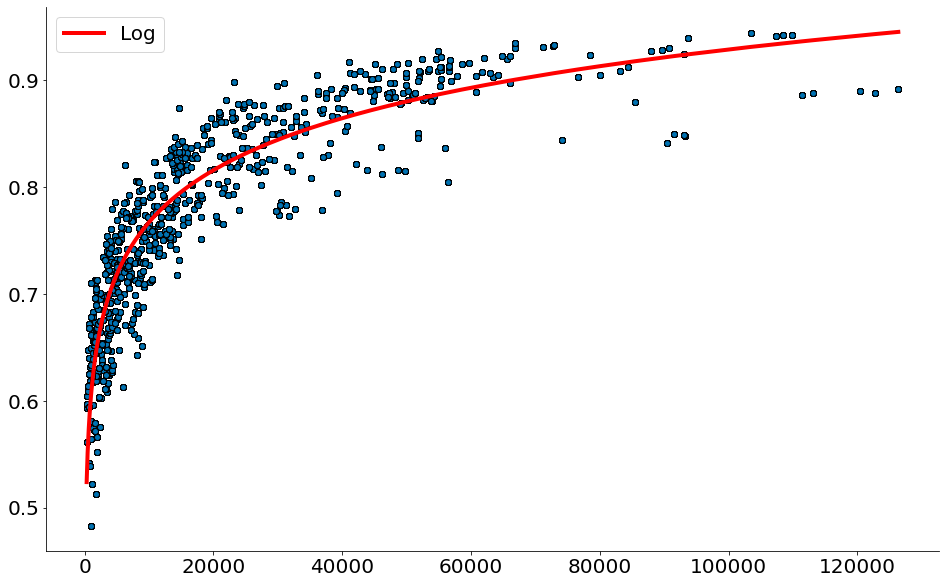

In [ ]:
colx = 'GDP per capita'
coly = 'HDI'

X = df.dropna()[[colx]]
y = df.dropna()[[coly]]

X_sorted = X.sort_values(by=colx)
y_sorted = y.sort_values(by=coly)

X_log = np.log(X)
X_log_sorted = np.log(X_sorted)

for k in range(1):
    sc = StandardScaler()

    poly_features = PolynomialFeatures(degree=k+1, include_bias=False)
    linear = LinearRegression()
    lasso = GridSearchCV(Lasso(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
    ridge = GridSearchCV(Ridge(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
    knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})


    poly_reg_model = Pipeline([
        ('std_scaler', sc),
        ('poly', poly_features),
        ('regressor', linear)
    ])

    poly_reg_model.fit(X_log, y)

    y_hat = poly_reg_model.predict(X_log_sorted)

    plt.plot(X_sorted, y_hat, color='r', label='Log')
    # print('Coeficientes:', lin_reg.coef_)
    # print('Intercepto:', lin_reg.intercept_)

    precision = poly_reg_model.score(X_log, y)

    print('R2:', precision)

plt.scatter(X, y, edgecolors='k')

plt.legend()

despine()

plt.show()

R2 grau 1: 0.09314305417925073

R2 grau 2: 0.16289322786181504

R2 grau 3: 0.20165778291837355

R2 grau 4: 0.23124677224339651

R2 grau 5: 0.2542766252944254

R2 grau 6: 0.2777744244053578

R2 grau 7: 0.2946861099529996



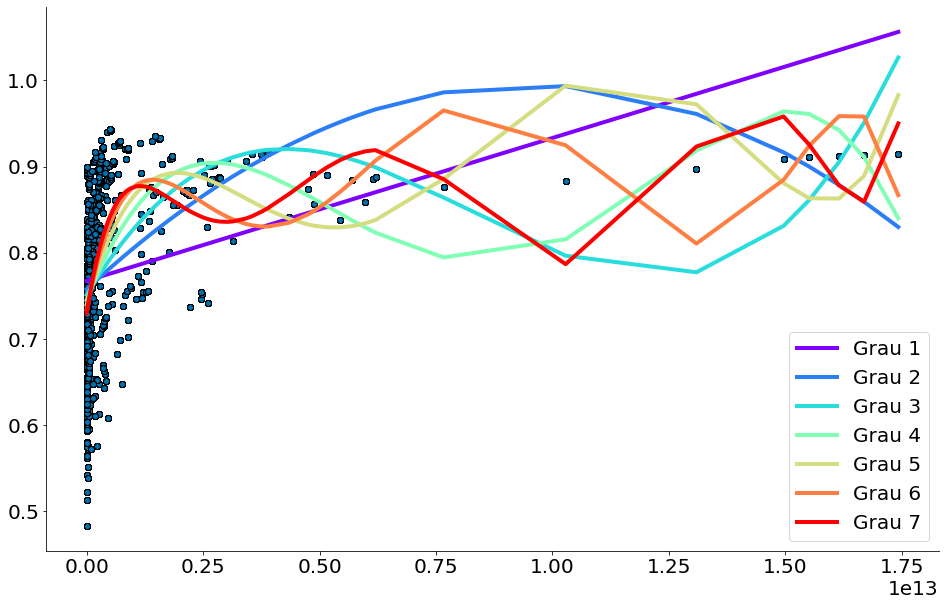

In [ ]:
colx = 'GDP'
coly = 'HDI'

n_iters = 7

color = iter(cm.rainbow(np.linspace(0, 1, n_iters)))

X = df.dropna()[[colx]]
y = df.dropna()[[coly]]

X_sorted = X.sort_values(by=colx)
y_sorted = y.sort_values(by=coly)

sc = StandardScaler()
for k in range(n_iters):
    poly_features = PolynomialFeatures(degree=k+1, include_bias=False)
    lin_reg = LinearRegression()

    poly_reg_model = Pipeline([
        ('std_scaler', sc),
        ('poly', poly_features),
        ('regressor', lin_reg)
    ])
    
    poly_reg_model.fit(X, y)

    y_hat = poly_reg_model.predict(X_sorted)
    
    c = next(color)
    plt.plot(X_sorted, y_hat, color=c, label='Grau ' + str(k+1))
    # print('Coeficientes:', lin_reg.coef_)
    # print('Intercepto:', lin_reg.intercept_)

    precision = poly_reg_model.score(X, y)

    print('R2 grau', str(k + 1) + ':', precision)
    print()

plt.scatter(X, y, edgecolors='k')

plt.legend()

despine()

plt.show()

R2: 0.35359777057063835


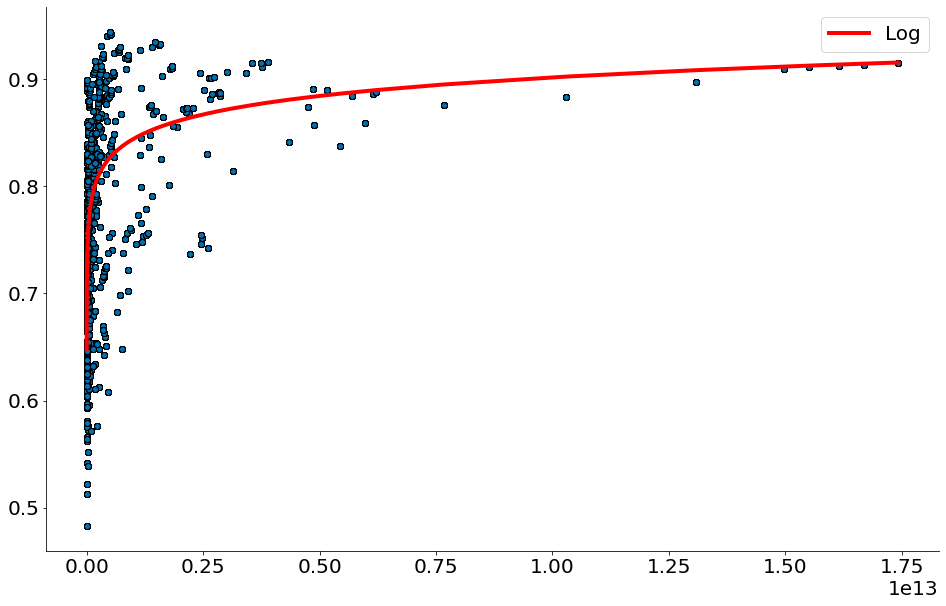

In [ ]:
colx = 'GDP'
coly = 'HDI'

X = df.dropna()[[colx]]
y = df.dropna()[[coly]]

X_sorted = X.sort_values(by=colx)
y_sorted = y.sort_values(by=coly)

X_log = np.log(X)
X_log_sorted = np.log(X_sorted)

for k in range(1):
    sc = StandardScaler()

    poly_features = PolynomialFeatures(degree=k+1, include_bias=False)
    linear = LinearRegression()
    lasso = GridSearchCV(Lasso(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
    ridge = GridSearchCV(Ridge(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
    knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})


    poly_reg_model = Pipeline([
        ('std_scaler', sc),
        ('poly', poly_features),
        ('regressor', linear)
    ])

    poly_reg_model.fit(X_log, y)

    y_hat = poly_reg_model.predict(X_log_sorted)

    plt.plot(X_sorted, y_hat, color='r', label='Log')
    # print('Coeficientes:', lin_reg.coef_)
    # print('Intercepto:', lin_reg.intercept_)

    precision = poly_reg_model.score(X_log, y)

    print('R2:', precision)

plt.scatter(X, y, edgecolors='k')

plt.legend()

despine()

plt.show()

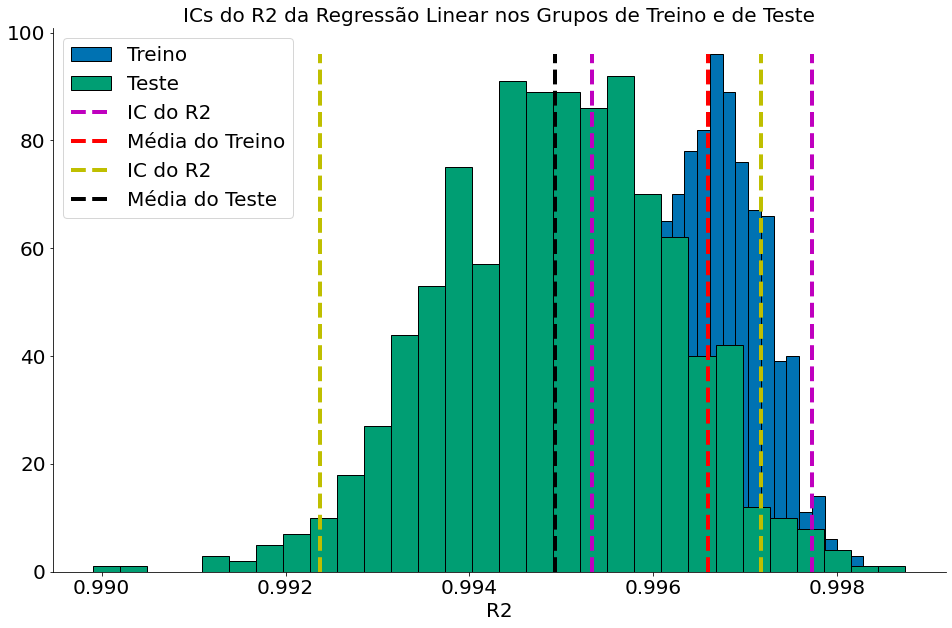

In [ ]:
colx = 'GDP per capita'
coly = 'HDI'

X = np.log(df.dropna()[[colx]])
y = df.dropna()[[coly]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

sc = StandardScaler()

poly_features = PolynomialFeatures(degree=1, include_bias=False)
linear = LinearRegression()
lasso = GridSearchCV(Lasso(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
ridge = GridSearchCV(Ridge(), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})

poly_reg_model = Pipeline([
    ('std_scaler', sc),
    ('poly', poly_features),
    ('regressor', knn)
])

poly_reg_model.fit(X_train, y_train)

r2_values0 = bootstrap_score(X_train, y_train, poly_reg_model, n=1000)
r2_values1 = bootstrap_score(X_test, y_test, poly_reg_model, n=1000)

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
M0 = r2_values0.mean()

LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)
M1 = r2_values1.mean()

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do R2', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(M0, ymin, maior, linestyles='--', label='Média do Treino', color='r')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do R2', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.vlines(M1, ymin, maior, linestyles='--', label='Média do Teste', color='k')

plt.xlabel('R2')
plt.title('ICs do R2 da Regressão Linear nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()


# 6. Separação dos Grupos

In [ ]:
df.columns

Index(['Country', 'Year', 'Sex', 'Age', 'Suicides', 'Population',
       'Suicides/100k', 'HDI', 'GDP', 'GDP per capita', 'Generation'],
      dtype='object')

Regressão 100k (talvez GDP p/c ou até HDI)

Class Sex, Age, Gen

## 1. Regressão em Suicides/100k

Separamos os grupos de treino e teste. Escolhemos deixar as duas colunas que contém outras informações sobre o GDP porque uma delas é relativa (e também depende do tamanho da população) e a outra não diz nada sobre o valor absoluto do GDP (por mais que seja mais difícil um GDP já alto crescer).

### 1. Versão com dropna

In [ ]:
X = df.copy()
X = X.dropna()
y = X['Suicides/100k']

X = X.drop(['Suicides/100k', 'Country'], axis=1)

### 2. Versão com fillna

In [ ]:
# X = df.copy()
# X = X.drop(['Suicides/100k', 'Country'], axis=1)
# X['HDI'] = X['HDI'].fillna(X['HDI'].mean())

# y = df['Suicides/100k']

### 3. Continuação

In [ ]:
non_strings = []

for i, col in enumerate(X.columns):
    if X.dtypes[i] != np.dtype('object'):
        non_strings.append(col)

In [ ]:
df.columns

Index(['Country', 'Year', 'Sex', 'Age', 'Suicides', 'Population',
       'Suicides/100k', 'HDI', 'GDP', 'GDP per capita', 'Generation'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

non_strings = non_strings[:-1]
mean_train = X_train[non_strings].mean()
std_train = X_train[non_strings].std(ddof=1)

Z_train = X_train.copy()
Z_train[non_strings] = Z_train[non_strings] - mean_train
Z_train[non_strings] = Z_train[non_strings] / std_train

Z_test = X_test.copy()
Z_test[non_strings] = Z_test[non_strings] - mean_train
Z_test[non_strings] = Z_test[non_strings] / std_train

Transformamos as colunas categóricas em numéricas.

In [ ]:
D_train = pd.get_dummies(Z_train, prefix='', prefix_sep='')
D_test = pd.get_dummies(Z_test, prefix='', prefix_sep='')

# 7. Fit dos Modelos

Usamos o SKLearn, de novo, para fazer a Regressão Linear Múltipla e mostramos os coeficientes para cada coluna do DataFrame de teste.



In [ ]:
linear = LinearRegression(fit_intercept=False)
lasso = GridSearchCV(Lasso(fit_intercept=False), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
ridge = GridSearchCV(Ridge(fit_intercept=False), cv=3, refit=True, param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 100]})
knn = GridSearchCV(KNeighborsRegressor(), cv=3, refit=True, param_grid={'n_neighbors': [2, 3, 5, 7, 11, 13], 'weights': ['uniform', 'distance']})

Fazemos, então o fit de cada modelo e mostramos seu Coeficiente de Determinação.

In [ ]:
linear = linear.fit(D_train, y_train)
linear.score(D_train, y_train)

0.37081650324075277

In [ ]:
lasso = lasso.fit(D_train, y_train)
lasso.score(D_train, y_train)

0.3707478830956016

Nos casos do Lasso, Ridge e KNN mostramos também os melhores hiper-parâmetros.

In [ ]:
lasso.best_params_

{'alpha': 0.01}

In [ ]:
ridge = ridge.fit(D_train, y_train)
ridge.score(D_train, y_train)

0.3707324609396567

In [ ]:
ridge.best_params_

{'alpha': 10}

In [ ]:
knn = knn.fit(D_train, y_train)
knn.score(D_train, y_train)

1.0

In [ ]:
knn.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

# Class Sex, Age, Gen

# 9. Classificação Sexo

## 1. Pré-processamento de Dados

In [ ]:
# col = 'Age'
# col = 'Generation'
col = 'Sex'

X = df.copy()
X = X.dropna()
y = X[col]

X = X.drop([col, 'Country'], axis=1)

In [ ]:
# classes = y.unique()

# for i in range(len(classes)):
#     y[y == classes[i]] = i

In [ ]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

In [ ]:
non_strings = []

for i, col in enumerate(X.columns):
    if X.dtypes[i] != np.dtype('object'):
        non_strings.append(col)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

non_strings = non_strings[:-1]
mean_train = X_train[non_strings].mean()
std_train = X_train[non_strings].std(ddof=1)

Z_train = X_train.copy()
Z_train[non_strings] = Z_train[non_strings] - mean_train
Z_train[non_strings] = Z_train[non_strings] / std_train

Z_test = X_test.copy()
Z_test[non_strings] = Z_test[non_strings] - mean_train
Z_test[non_strings] = Z_test[non_strings] / std_train

Transformamos as colunas categóricas em numéricas.

In [ ]:
D_train = pd.get_dummies(Z_train, prefix='', prefix_sep='')
D_test = pd.get_dummies(Z_test, prefix='', prefix_sep='')

## 2. Classificação

In [ ]:
skf = StratifiedKFold(n_splits=5)
fold = 1

for train_index, val_index in skf.split(D_train, y_train):

    print('Fold:', fold)
    for k in [1, 3, 5, 7, 9, 11, 13, 15]:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(D_train.values[train_index],
                  y_train.values[train_index])

        y_val = y_train.values[val_index]
        y_hat = model.predict(D_train.values[val_index])

        # precision = np.mean(precision_score(y_val, y_hat, average=None))
        precision = precision_score(y_val, y_hat, average=None)
        print(k, 'Neighbors:', precision)
    print()
    print()
    fold += 1

Fold: 1
1 Neighbors: [0.38607595 0.34693878]
3 Neighbors: [0.49632893 0.47346939]
5 Neighbors: [0.49287749 0.46695096]
7 Neighbors: [0.448737   0.40963855]
9 Neighbors: [0.45014663 0.40899796]
11 Neighbors: [0.46857143 0.43099788]
13 Neighbors: [0.46723647 0.42857143]
15 Neighbors: [0.47901592 0.44791667]


Fold: 2
1 Neighbors: [0.35634029 0.31751825]
3 Neighbors: [0.50997151 0.49253731]
5 Neighbors: [0.49789621 0.47379913]
7 Neighbors: [0.46255507 0.42653061]
9 Neighbors: [0.46175637 0.41935484]
11 Neighbors: [0.47360913 0.43829787]
13 Neighbors: [0.46618705 0.42857143]
15 Neighbors: [0.46131805 0.42071882]


Fold: 3
1 Neighbors: [0.35901639 0.32798574]
3 Neighbors: [0.49273256 0.4679089 ]
5 Neighbors: [0.47578348 0.44136461]
7 Neighbors: [0.44311377 0.40357853]
9 Neighbors: [0.45870206 0.42190669]
11 Neighbors: [0.46657183 0.42735043]
13 Neighbors: [0.457223   0.41048035]
15 Neighbors: [0.45931034 0.4103139 ]


Fold: 4
1 Neighbors: [0.375      0.33209647]
3 Neighbors: [0.49570201 0.4

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(D_train.values, y_train.values)

pscore_values0 = bootstrap_pscore(y_train.values, model.predict(D_train.values))
pscore_values1 = bootstrap_pscore(y_test.values, model.predict(D_test.values))

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do PScore', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do PScore', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')

plt.xlabel('Precision Score')
plt.title('ICs do Precision Score da Classificação KNN nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

ValueError: ignored

# 10. Conclusão <a name="concl"></a>

O projeto criou oportunidades para o aprendizado de várias técnicas, conceitos e ferramentas do arcabouço de Ciência de Dados. Além do mais, foi possível perceber a importância de apresentar os dados de forma a aumentar a legibilidade deles pelo leitor.

Autor: Lucas S. Teles